In [5]:
import time
import random 
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import jv
from scipy.integrate import simps
from scipy.integrate import quad
from scipy.stats import powerlaw

In [6]:
year = 3.1536e7               #Seconds in a year
M_sun = 1.9891e30             #Mass of sun in kg
R_sun = 696340000             #Radius of Sun
M_Ch = 1.435 * M_sun          #Chandra Mass in kg
G = 6.6743e-11                #gravitational constant in m^3/kg/s^2
c = 299792458                 #speed in m/s
D = 3.086e19                  #Distance in meters (1 kpc)
AU = 1.496e+11                #Meters in an AU
m1 = 0.5 * M_sun              #Mass of WD1 in kg
m2 = 0.5 * M_sun              #Mass of WD2 in kg
mu = (m1 * m2)/(m1 + m2)      #Reduced Mass of system in kg
M = m1 + m2                   #Total mass of system in kg
radius = ((7.8e8*((m1/M_Ch)**(-1/3))*((1-((m1/M_Ch)**(4/3)))**(1/2)))/100)              #Radius of the stars (m)
fres = 1 / (5 * year)         #Frequency Resolution

In [7]:
#Define separation limits
a_min = 2 * radius
a_max = 0.05 * AU

In [8]:
def a_power_law_sampling(size, c, a_lower_bound, a_upper_bound, a_scaling_index):
    # Calculate the normalization constant
    a_norm = quad(lambda x: x ** a_scaling_index, a_lower_bound, a_upper_bound)[0]

    # Generate random numbers from a uniform distribution
    u = np.random.uniform(size=size)

    # Apply the power-law transformation
    x = ((a_scaling_index + 1) * u * a_norm + a_lower_bound ** (a_scaling_index + 1)) ** (1 / (a_scaling_index + 1))

    return x

def e_thermal_sampling(size):
    # Generate random numbers from a uniform distribution between 0 and 1
    u = np.random.uniform(size=size)

    # Apply the inverse transform to obtain the thermal samples
    e = np.sqrt(u)

    return e

# Parameters
sample_size = 1
a_scaling_index = -2
a_normalization_coefficient = c
a_lower_bound = a_min
a_upper_bound = a_max

In [9]:
#Define our differential equations
def dnudt(e0, nu0):
    dnudt = (96/(10*np.pi))*(((c**6)*mu)/((M**3)*(G**2)))*((2*np.pi*(G*M/(c**3)*nu0))**(11/3))*((1-(e0**2))**(-9/2))*((1+((73/24)*(e0**2))+((37/96)*(e0**4)))*(1-(e0**2)))
    return dnudt

def dedt(e0, nu0):
    dedt = -1*(e0/15)*(((c**3)*mu)/((M**2)*G))*((1-(e0**2))**(-7/2))*((2*np.pi*(G*M/(c**3)*nu0))**(8/3))*((304+(121*(e0**2)))*(1-(e0**2)))
    return dedt

In [10]:
#Define the characteristic time
def calculate_t_char(e0, nu0):
    t_char = nu0 / dnudt(e0, nu0)
    return t_char

t_M = (G * M)/(c**3)

In [11]:
#Define our coupled differential equations to solve
#Must declare t_char as an initial condition with a zero derivative or else solve_ivp gets very mad
def coupled_odes(t, y):
    A, e, t_char = y
    
    dAdt  = (96/(10*np.pi))*((t_char/t_M)*(mu/M))*((2*np.pi*A)**(11/3))*((1-(e**2))**(-9/2))*((1+((73/24)*(e**2))+((37/96)*(e**4)))*(1-(e**2)))
    
    dedt = -1*(e/15)*((t_char/t_M)*(mu/M))*((1-(e**2))**(-7/2))*((2*np.pi*A)**(8/3))*((304+(121*(e**2)))*(1-(e**2)))
    
    dt_chardt = 0
    
    return [dAdt, dedt, dt_chardt]

In [12]:
#Write a Monte Carlo simulation
def MonteCarlo1(num_systems):
    #Initialize the population array
    population = np.empty((num_systems, 6))
    #Begin system generating loop
    for i in range(num_systems):
        
        #Generate random parameters
        #from distributions of choice
        a0 = float(a_power_law_sampling(sample_size, a_normalization_coefficient, a_lower_bound, a_upper_bound, a_scaling_index))
        nu0 = np.sqrt((G*M)/(4*(np.pi**2)*(a0**3)))
        
        #An initial mixing ration of about 1:3 will provide us with 10% of final systems in LISA's band being eccentric
        if i < (0.28 * num_systems):
            e0 = float(e_thermal_sampling(sample_size))
        else:
            e0 = 0
        
        age0 = np.random.uniform(0, 1e9 * year)
        
        #---------------------------#
        # Calculate the constant for the current initial condition
        t_char = calculate_t_char(e0, nu0)
        A0 = t_M * nu0
        #Initial Time
        t0 = 0
        #Final Time
        tf = (age0)/t_char
        #Define a time frame
        t_span = [t0, tf]
        
        if tf <= 0.2:
            population[i] = (a0, e0, a0, e0, age0, t_char)
            
        elif tf >= 5:
            population[i] = (a0, e0, np.NaN, np.NaN, age0, t_char)
            
        else:
            # Solve the differential equations for each initial condition
            sol = solve_ivp(coupled_odes, t_span, [A0, e0, t_char])
        
            # Extract the solution
            e_solution = sol.y[1]
            nu_solution = sol.y[0] / t_M
        
            ef = e_solution[-1]
            nuf = nu_solution[-1]
        
            af = np.cbrt(((1/nuf)**2)*((G*M)/(4*(np.pi**2))))
            separation = af * (1 - ef)
        
            if separation <= 2 * radius:
                af = np.NaN
                ef = np.NaN
            
            delta_nu = nuf - nu0
        
            if delta_nu <= fres:
                af = np.NaN
                ef = np.NaN
        
            #---------------------------#
        
            #Append results to population array
            population[i] = (a0, e0, af, ef, age0, t_char)
        
    return population

def MonteCarlo2(num_systems):
    #Initialize the population array
    population = np.empty((num_systems, 6))
    #Begin system generating loop
    for i in range(num_systems):
        
        #Generate random parameters
        #from distributions of choice
        a0 = float(a_power_law_sampling(sample_size, a_normalization_coefficient, a_lower_bound, a_upper_bound, a_scaling_index))
        nu0 = 1 / np.sqrt(((4*(np.pi**2))/(G*M))*(a0**3))
        e0 = 0
        age0 = np.random.uniform(0, 1e9 * year)
        
        #---------------------------#
        # Calculate the constant for the current initial condition
        t_char = calculate_t_char(e0, nu0)
        A0 = t_M * nu0
        #Initial Time
        t0 = 0
        #Final Time
        tf = (age0)/t_char
        #Define a time frame
        t_span = [t0, tf]
        
        if tf <= 0.2:
            population[i] = (a0, e0, a0, e0, age0, t_char)
            
        elif tf >= 5:
            population[i] = (a0, e0, np.NaN, np.NaN, age0, t_char)
            
        else:
            # Solve the differential equations for each initial condition
            sol = solve_ivp(coupled_odes, t_span, [A0, e0, t_char])
        
            # Extract the solution
            e_solution = sol.y[1]
            nu_solution = sol.y[0] / t_M
        
            ef = e_solution[-1]
            nuf = nu_solution[-1]
        
            af = np.cbrt(((1/nuf)**2)*((G*M)/(4*(np.pi**2))))
            separation = af * (1 - ef)
        
            if separation <= 2 * radius:
                af = np.NaN
                ef = np.NaN
            
            delta_nu = nuf - nu0
        
            if delta_nu <= fres:
                af = np.NaN
                ef = np.NaN
        
            #---------------------------#
        
            #Append results to population array
            population[i] = (a0, e0, af, ef, age0, t_char)
        
    return population

def MonteCarlo3(num_systems):
    #Initialize the population array
    population = np.empty((num_systems, 6))
    #Begin system generating loop
    for i in range(num_systems):
        
        #Generate random parameters
        #from distributions of choice
        a0 = float(a_power_law_sampling(sample_size, a_normalization_coefficient, a_lower_bound, a_upper_bound, a_scaling_index))
        nu0 = 1 / np.sqrt(((4*(np.pi**2))/(G*M))*(a0**3))
        e0 = float(e_thermal_sampling(sample_size))
        age0 = np.random.uniform(0, 1e9 * year)
        
        #---------------------------#
        # Calculate the constant for the current initial condition
        t_char = calculate_t_char(e0, nu0)
        A0 = t_M * nu0
        #Initial Time
        t0 = 0
        #Final Time
        tf = (age0)/t_char
        #Define a time frame
        t_span = [t0, tf]
        
        if tf <= 0.2:
            population[i] = (a0, e0, a0, e0, age0, t_char)
            
        elif tf >= 5:
            population[i] = (a0, e0, np.NaN, np.NaN, age0, t_char)
            
        else:
            # Solve the differential equations for each initial condition
            sol = solve_ivp(coupled_odes, t_span, [A0, e0, t_char])
        
            # Extract the solution
            e_solution = sol.y[1]
            nu_solution = sol.y[0] / t_M
        
            ef = e_solution[-1]
            nuf = nu_solution[-1]
        
            af = np.cbrt(((1/nuf)**2)*((G*M)/(4*(np.pi**2))))
            separation = af * (1 - ef)
        
            if separation <= 2 * radius:
                af = np.NaN
                ef = np.NaN
            
            delta_nu = nuf - nu0
        
            if delta_nu <= fres:
                af = np.NaN
                ef = np.NaN
        
            #---------------------------#
        
            #Append results to population array
            population[i] = (a0, e0, af, ef, age0, t_char)
        
    return population

In [32]:
start_time = time.time()

pop1 = MonteCarlo1(1000000) #Mixed
pop2 = MonteCarlo2(1000000) #Circular
pop3 = MonteCarlo3(1000000) #Eccentric

end_time = time.time()

elapsed_time = end_time - start_time

a0_values1 = pop1[:,0]/AU
e0_values1 = pop1[:,1]
af_values1 = pop1[:,2]/AU
ef_values1 = pop1[:,3]
age_values1 = pop1[:,4]
t_char_values1 = pop1[:,5]/year

a0_values2 = pop2[:,0]/AU
e0_values2 = pop2[:,1]
af_values2 = pop2[:,2]/AU
ef_values2 = pop2[:,3]
age_values2 = pop2[:,4]
t_char_values2 = pop2[:,5]/year

a0_values3 = pop3[:,0]/AU
e0_values3 = pop3[:,1]
af_values3 = pop3[:,2]/AU
ef_values3 = pop3[:,3]
age_values3 = pop3[:,4]
t_char_values3 = pop3[:,5]/year

print(elapsed_time, 'Seconds')

/tmp/ipykernel_27076/2456728461.py:6: RuntimeWarning: invalid value encountered in scalar power
  dAdt  = (96/(10*np.pi))*((t_char/t_M)*(mu/M))*((2*np.pi*A)**(11/3))*((1-(e**2))**(-9/2))*((1+((73/24)*(e**2))+((37/96)*(e**4)))*(1-(e**2)))
/tmp/ipykernel_27076/2456728461.py:8: RuntimeWarning: invalid value encountered in scalar power
  dedt = -1*(e/15)*((t_char/t_M)*(mu/M))*((1-(e**2))**(-7/2))*((2*np.pi*A)**(8/3))*((304+(121*(e**2)))*(1-(e**2)))


881.0316278934479 Seconds


In [33]:
nan_count1 = np.sum(np.isnan(af_values1))
aff_values1 = af_values1[~np.isnan(af_values1)]
eff_values1 = ef_values1[~np.isnan(ef_values1)]

final_eccentric_systems = np.column_stack((aff_values1, eff_values1))

print(nan_count1, "systems have been eliminated.")
print("Only", len(af_values1)-nan_count1, "systems remain.")

aff_min = np.cbrt(((1/0.0001)**2)*((G*M)/(4*(np.pi**2))))/AU
aff_max = np.cbrt(((1/1)**2)*((G*M)/(4*(np.pi**2))))/AU

in_LISA_band = final_eccentric_systems[(final_eccentric_systems[:,0] >= aff_max) & (final_eccentric_systems[:,0] <= aff_min)]
num_zeros = np.count_nonzero(in_LISA_band[:,1] == 0)
percent_above_pone = np.count_nonzero(in_LISA_band[:,1] >= 0.1)

iLbf = in_LISA_band[:,0]*AU
in_LISA_band_freq = 1 / np.sqrt(((4*(np.pi**2))/(G*M))*(iLbf**3))

print('Only', len(in_LISA_band), 'systems are orbiting within the sensitivity band of LISA.')
print('Only', len(in_LISA_band)-num_zeros, 'of the systems LISA can detect are eccentric.')
print(f"{(percent_above_pone/len(in_LISA_band))*100:.3f}", 'percent of the systems LISA can detect have an eccentricity greater than 0.1')

973356 systems have been eliminated.
Only 26644 systems remain.
Only 7173 systems are orbiting within the sensitivity band of LISA.
Only 795 of the systems LISA can detect are eccentric.
10.052 percent of the systems LISA can detect have an eccentricity greater than 0.1


In [34]:
nan_count2 = np.sum(np.isnan(af_values2))
aff_values2 = af_values2[~np.isnan(af_values2)]
eff_values2 = ef_values2[~np.isnan(ef_values2)]

final_circular_systems = np.column_stack((aff_values2, eff_values2))

print(nan_count2, "systems have been eliminated.")
print("Only", len(af_values2)-nan_count2, "systems remain.")

aff_min = np.cbrt(((1/0.0001)**2)*((G*M)/(4*(np.pi**2))))/AU
aff_max = np.cbrt(((1/1)**2)*((G*M)/(4*(np.pi**2))))/AU

in_LISA_band2 = final_circular_systems[(final_circular_systems[:,0] >= aff_max) & (final_circular_systems[:,0] <= aff_min)]

iLbf2 = in_LISA_band2[:,0]*AU
in_LISA_band_freq2 = 1 / np.sqrt(((4*(np.pi**2))/(G*M))*(iLbf2**3))

print('Only', len(in_LISA_band2), 'systems are orbiting within the sensitivity band of LISA.')

968743 systems have been eliminated.
Only 31257 systems remain.
Only 8707 systems are orbiting within the sensitivity band of LISA.


In [35]:
nan_count3 = np.sum(np.isnan(af_values3))
aff_values3 = af_values3[~np.isnan(af_values3)]
eff_values3 = ef_values3[~np.isnan(ef_values3)]

final_e_systems = np.column_stack((aff_values3, eff_values3))

print(nan_count3, "systems have been eliminated.")
print("Only", len(af_values3)-nan_count3, "systems remain.")

aff_min = np.cbrt(((1/0.0001)**2)*((G*M)/(4*(np.pi**2))))/AU
aff_max = np.cbrt(((1/1)**2)*((G*M)/(4*(np.pi**2))))/AU

in_LISA_band3 = final_e_systems[(final_e_systems[:,0] >= aff_max) & (final_e_systems[:,0] <= aff_min)]
num_zeros3 = np.count_nonzero(in_LISA_band3[:,1] == 0)
percent_above_pone3 = np.count_nonzero(in_LISA_band3[:,1] >= 0.1)

iLbf3 = in_LISA_band3[:,0]*AU
in_LISA_band_freq3 = 1 / np.sqrt(((4*(np.pi**2))/(G*M))*(iLbf3**3))

print('Only', len(in_LISA_band3), 'systems are orbiting within the sensitivity band of LISA.')
print('Only', len(in_LISA_band3)-num_zeros3, 'of the systems LISA can detect are eccentric.')
print(f"{(percent_above_pone3/len(in_LISA_band3))*100:.3f}", 'percent of the systems LISA can detect have an eccentricity greater than 0.1')

985020 systems have been eliminated.
Only 14980 systems remain.
Only 2841 systems are orbiting within the sensitivity band of LISA.
Only 2841 of the systems LISA can detect are eccentric.
91.939 percent of the systems LISA can detect have an eccentricity greater than 0.1


In [45]:
def plot_loghisti(x, bins, label):
    hist, bins = np.histogram(x, bins=bins, density=True)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, label=label, histtype='step')
    #plt.plot(x, x**(-1), 'r-')
    bin_widths = np.diff(bins)
    bin_areas = hist * bin_widths
    total_area = np.sum(bin_areas)
    plt.title("Histogram of Initial Separation")
    plt.xlabel("Separation (AU)")
    plt.ylabel("P(a)")
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0.00009,1)
    #plt.ylim(0,10**8)
    plt.grid()
    print('This histogram has been properly normalized! Its total area is equal to', f"{total_area:.3f}")

def plot_loghistf(x, bins, label):
    hist, bins = np.histogram(x, bins=bins, density=True)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, alpha=1, label=label, histtype='step')
    #plt.plot(x, 3000*(x/0.007)**(-2), 'r--')
    #plt.plot(x, 3000*(x/0.007)**(+2), 'r--')
    bin_widths = np.diff(bins)
    bin_areas = hist * bin_widths
    total_area = np.sum(bin_areas)
    plt.title("Histogram of Final Separation")
    plt.xlabel("Separation (AU)")
    plt.ylabel("P(a)")
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0.00009,0.02)
    plt.ylim(1,10000)
    plt.grid()
    print('This histogram has been properly normalized! Its total area is equal to', f"{total_area:.3f}")
    
def plot_loghistffreq(x, bins, label):
    hist, bins = np.histogram(x, bins=bins, density=True)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, alpha=0.5, label=label)
    plt.plot(x, 2100*(x/0.0001)**(-3), 'r-')
    bin_widths = np.diff(bins)
    bin_areas = hist * bin_widths
    total_area = np.sum(bin_areas)
    plt.title("Density Histogram of Final Frequencies in LISA Band")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("P(f)")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.00009,0.02)
    plt.ylim(1,10000)
    plt.grid()
    print('This histogram has been properly normalized! Its total area is equal to', f"{total_area:.3f}")
    
def plot_loghist_backup(x, bins, label):
    hist, bins = np.histogram(x, bins=bins, density=True)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, alpha=1, label=label, histtype='step')
    plt.plot(x, 1000*(x/0.0001)**(-3), 'r-')
    bin_widths = np.diff(bins)
    bin_areas = hist * bin_widths
    total_area = np.sum(bin_areas)
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0.00009,0.02)
    plt.ylim(1,10000)
    plt.grid()
    print('This histogram has been properly normalized! Its total area is equal to', f"{total_area:.3f}")
    
    
def plot_loghist_nu(xxx, bins, ax):
    hist, logbins = np.histogram(np.log(xxx), bins=bins)
    mid = np.exp((logbins[1:] + logbins[:-1])/2.)
    width = np.diff(logbins)
    prob_den_wrt_log = hist/width
    prob_den = prob_den_wrt_log/mid
    
    ax.step(mid, prob_den, where='mid')
    
    print(np.sum(hist*width))
    return ax
    
    
    
def plot_loghist2(x, bins, label):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, alpha=1, label=label, histtype='step')
    #plt.plot(x, 1000*(x/0.0001)**(-3), 'r-')
    bin_widths = np.diff(bins)
    bin_areas = hist * bin_widths
    total_area = np.sum(bin_areas)
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0.00009,0.02)
    #plt.ylim(1,10000)
    plt.grid()
    print('This histogram has been properly normalized! Its total area is equal to', f"{total_area:.3f}")

This histogram has been properly normalized! Its total area is equal to 1.000
This histogram has been properly normalized! Its total area is equal to 1.000
This histogram has been properly normalized! Its total area is equal to 1.000


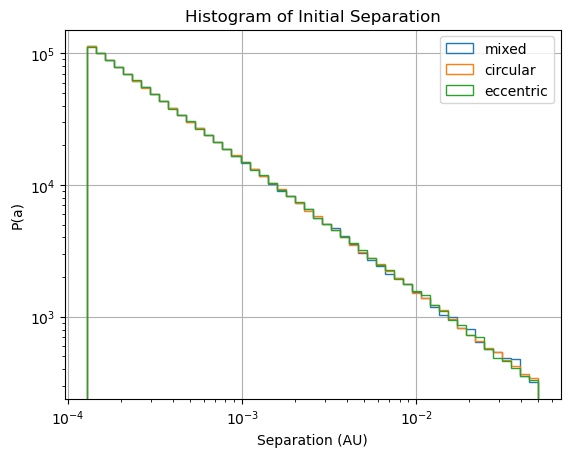

In [46]:
plot_loghisti(a0_values1,50,'mixed')
plot_loghisti(a0_values2,50,'circular')
plot_loghisti(a0_values3,50,'eccentric')
plt.legend()

This histogram has been properly normalized! Its total area is equal to 1.000
This histogram has been properly normalized! Its total area is equal to 1.000
This histogram has been properly normalized! Its total area is equal to 1.000


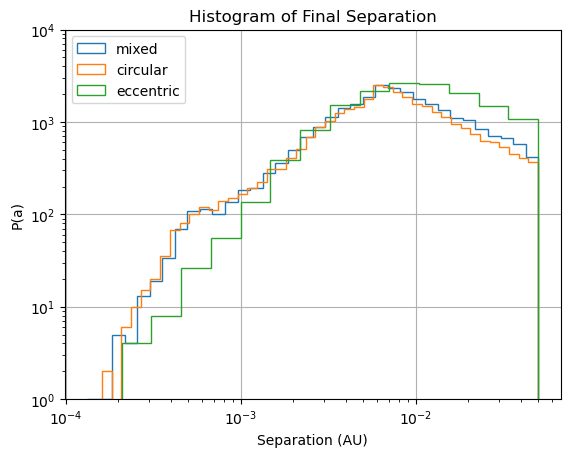

In [47]:
plot_loghistf(aff_values1,36,'mixed')
plot_loghistf(aff_values2,45,'circular')
plot_loghistf(aff_values3,14,'eccentric')
plt.legend()

This histogram has been properly normalized! Its total area is equal to 88.574
This histogram has been properly normalized! Its total area is equal to 103.853
This histogram has been properly normalized! Its total area is equal to 49.720


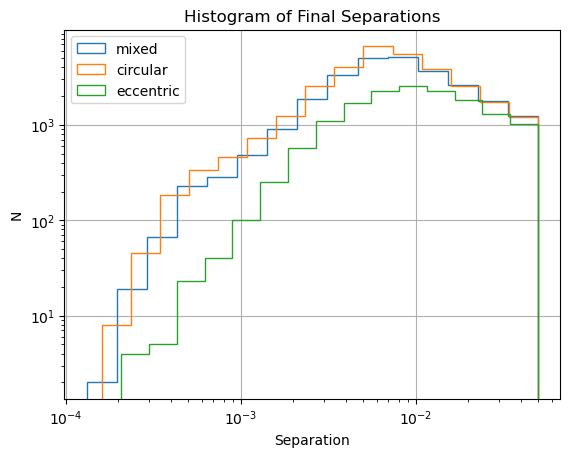

In [48]:
plot_loghist2(aff_values1,15,'mixed')
plot_loghist2(aff_values2,15,'circular')
plot_loghist2(aff_values3,15,'eccentric')
plt.xlabel('Separation')
plt.ylabel('N')
plt.legend()
plt.title('Histogram of Final Separations')

plt.show()

2926.9186434142393


(100.0, 10000000000.0)

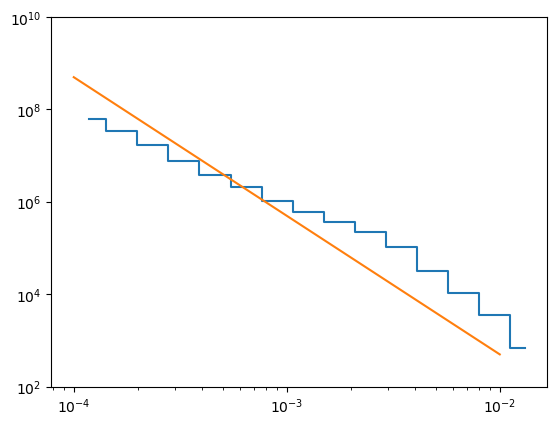

In [51]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax = plot_loghist_nu(in_LISA_band_freq2, 15, ax=ax)
nu_array = np.linspace(1e-4, 1e-2,100)
ax.loglog(nu_array, 5e8 * (nu_array/nu_array[0])**(-3))

ax.set_ylim(1e2, 1e10)

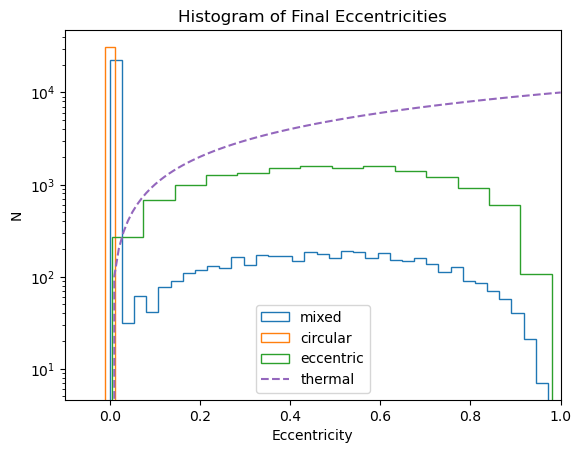

In [41]:
e_array = np.linspace(0,1,100)

plt.hist(eff_values1,bins=36,histtype='step',label='mixed')
plt.hist(eff_values2,bins=45,histtype='step',label='circular')
plt.hist(eff_values3,bins=14,histtype='step',label='eccentric')
plt.plot(e_array, 10000*e_array, color='tab:purple', ls='--', label='thermal')
plt.xlim(-0.1,1)
plt.yscale('log')
plt.xlabel('Eccentricity')
plt.ylabel('N')
plt.legend()
plt.title('Histogram of Final Eccentricities')

plt.show()

This histogram has been properly normalized! Its total area is equal to 1.000
This histogram has been properly normalized! Its total area is equal to 1.000
This histogram has been properly normalized! Its total area is equal to 1.000


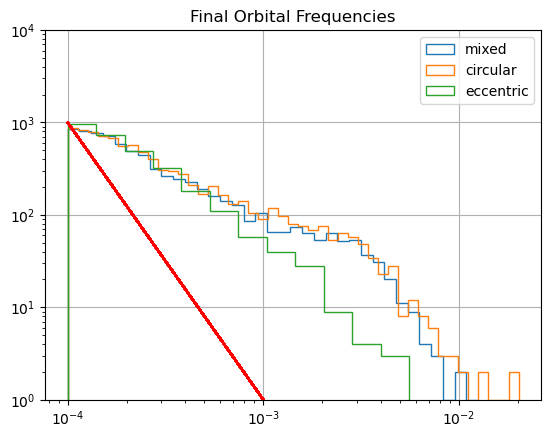

In [69]:
plot_loghist(in_LISA_band_freq,37,'mixed')
plot_loghist(in_LISA_band_freq2,45,'circular')
plot_loghist(in_LISA_band_freq3,14,'eccentric')
plt.title('Final Orbital Frequencies')
#plt.xlabel('Frequency [Hz]')
#plt.ylabel(r'P($\nu$)')
plt.legend()

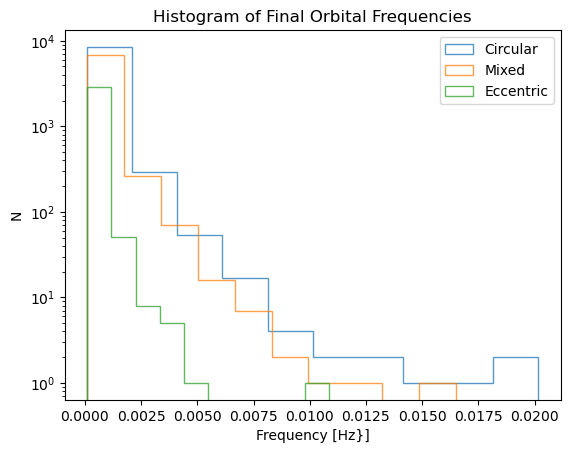

In [68]:
plt.hist(in_LISA_band_freq2, alpha=0.75,histtype='step', label='Circular')
plt.hist(in_LISA_band_freq, alpha=0.75,histtype='step', label='Mixed')
plt.hist(in_LISA_band_freq3,alpha=0.75,histtype='step', label='Eccentric')
plt.yscale('log')
plt.legend()
plt.title('Histogram of Final Orbital Frequencies')
plt.ylabel('N')
plt.xlabel('Frequency [Hz}]')
plt.show()

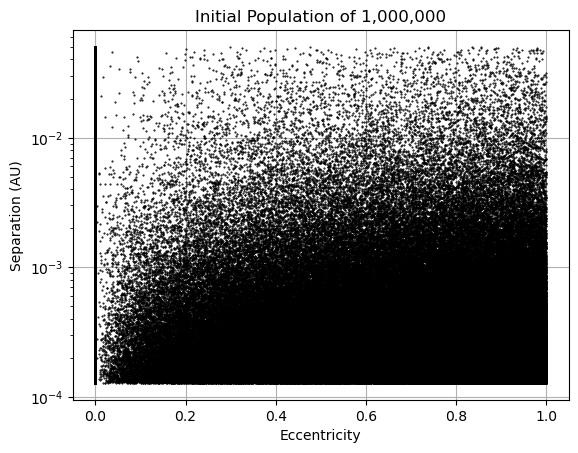

In [176]:
plt.plot(e0_values1, a0_values1, 'k.', ms = 1)
plt.xlabel('Eccentricity')
plt.ylabel('Separation (AU)')
plt.yscale('log')
plt.title('Initial Population of 1,000,000')
plt.grid()
plt.show()

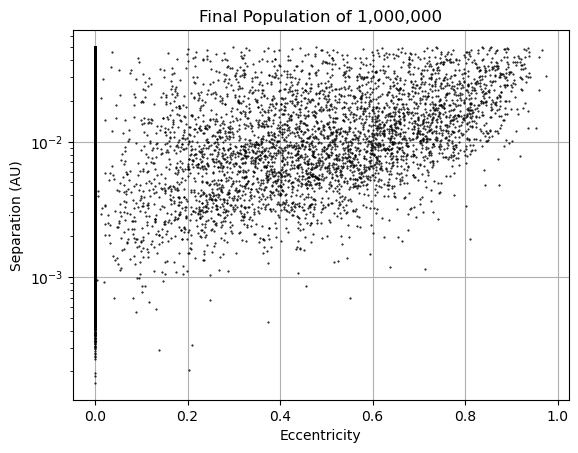

In [177]:
plt.plot(ef_values1, af_values1, 'k.', ms = 1)
plt.xlabel('Eccentricity')
plt.ylabel('Separation (AU)')
plt.yscale('log')
#plt.xscale('log')
plt.title('Final Population of 1,000,000')
plt.grid()
plt.show()

In [21]:
nu = np.sqrt((G*M)/(4*(np.pi**2)*(0.046**3)))
print(nu)
tchar = calculate_t_char(0,nu)
print(tchar)

185872249358.09155
9.653984136419105e-25


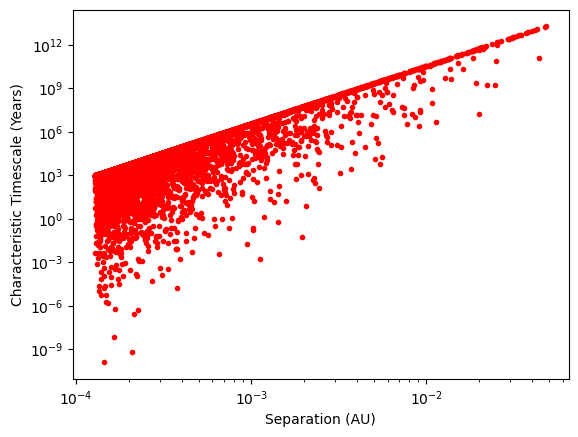

In [120]:
plt.plot(a0_values1, t_char_values1, 'r.')
plt.ylabel('Characteristic Timescale (Years)')
plt.xlabel('Separation (AU)')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [123]:
e = 0
nu = np.sqrt((G*M)/(4*(np.pi**2)*(a0_values1**3)))
dnudt = (96/(10*np.pi))*(((c**6)*mu)/((M**3)*(G**2)))*((2*np.pi*(G*M/(c**3)*nu))**(11/3))*((1-(e**2))**(-9/2))*((1+((73/24)*(e**2))+((37/96)*(e**4)))*(1-(e**2)))
a = a0_values1
dadt = (96/(10*np.pi))*(((c**6)*mu)/((M**3)*(G**2)))*((2*np.pi*(G*M/(c**3)*(np.sqrt((G*M)/(4*(np.pi**2)*(a0_values1**3))))))**(11/3))*((1-(e**2))**(-9/2))*((1+((73/24)*(e**2))+((37/96)*(e**4)))*(1-(e**2)))
t_nu = nu / dnudt
t_a = a / dadt

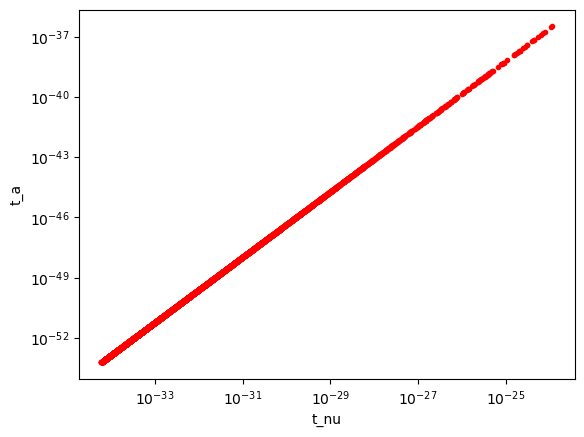

In [124]:
plt.plot(t_nu, t_a, 'r.')
plt.xlabel('t_nu')
plt.ylabel('t_a')
plt.xscale('log')
plt.yscale('log')
plt.show()